In [1]:
# OPTIONAL — RUN ONLY IF A PACKAGE IS MISSING
# Uncomment if your environment doesn’t have these:

# !pip install xgboost shap python-pptx joblib plotly
# !pip install scikit-learn seaborn matplotlib

In [3]:
MODELS_DIR = Path(r"C:\Users\swati\Desktop\BPIS\models")
MODELS_DIR.mkdir(parents=True, exist_ok=True)

REPORTS_DIR = Path(r"C:\Users\swati\Desktop\BPIS\reports")
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

CLEANED_OUT = Path(r"C:\Users\swati\Desktop\BPIS\superstore_cleaned.csv")
ML_FEATURE_CSV = Path(r"C:\Users\swati\Desktop\BPIS\BPIS_full_features.csv")

score_path = Path(r"C:\Users\swati\Desktop\BPIS\score_batch.py")

In [4]:
CSV_PATH = r"C:\Users\swati\Desktop\Revenue Analysis Project\Sample - Superstore.csv\Sample - Superstore.csv"

df = pd.read_csv(CSV_PATH, encoding="ISO-8859-1")
print(df.shape)
df.head()

(9994, 21)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [5]:
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_").str.replace("-", "_")

df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')
df['ship_date'] = pd.to_datetime(df['ship_date'], errors='coerce')

In [6]:
num_cols = df.select_dtypes(include=['int64','float64']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

cat_cols = df.select_dtypes(include=['object']).columns
for c in cat_cols:
    df[c] = df[c].fillna(df[c].mode()[0])

df = df.drop_duplicates().reset_index(drop=True)
df.isnull().sum().sort_values(ascending=False).head()

row_id        0
order_id      0
order_date    0
ship_date     0
ship_mode     0
dtype: int64

In [7]:
df['order_year'] = df['order_date'].dt.year
df['order_month'] = df['order_date'].dt.month
df['month_year_str'] = df['order_date'].dt.to_period("M").astype(str)

df['price'] = (df['sales'] / df['quantity']).replace([np.inf,-np.inf], 0)
df['revenue'] = df['sales']
df['aov'] = df['sales'] / df['quantity'].replace(0,1)
df['margin_pct'] = (df['profit'] / df['sales']).replace([np.inf,-np.inf], 0)

In [8]:
kpis = {
    "total_revenue": df['revenue'].sum(),
    "total_profit": df['profit'].sum(),
    "avg_order_value": df['aov'].mean(),
    "total_customers": df['customer_id'].nunique()
}
kpis

{'total_revenue': np.float64(2297200.8603),
 'total_profit': np.float64(286397.0217),
 'avg_order_value': np.float64(60.91956905143086),
 'total_customers': 793}

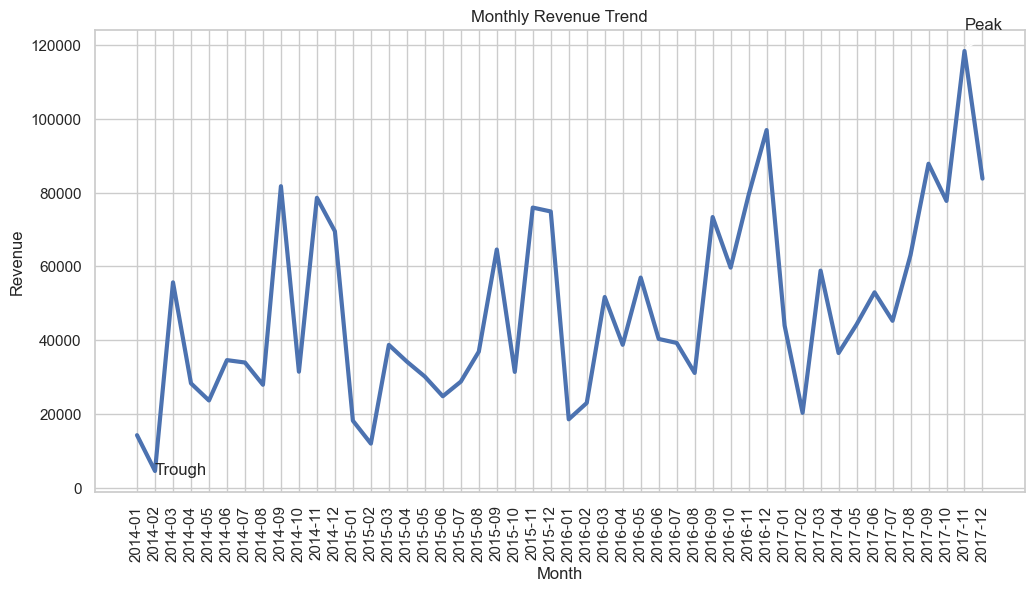

In [9]:
sns.set(style="whitegrid")

monthly_sales = df.groupby("month_year_str")['revenue'].sum().reset_index()

plt.figure(figsize=(12,6))
plt.plot(monthly_sales['month_year_str'], monthly_sales['revenue'], linewidth=3)
plt.xticks(rotation=90)
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Revenue")

max_m = monthly_sales['revenue'].idxmax()
min_m = monthly_sales['revenue'].idxmin()

plt.annotate("Peak", xy=(max_m, monthly_sales.loc[max_m,'revenue']), xytext=(max_m, monthly_sales['revenue'].max()*1.05), arrowprops=dict(arrowstyle="->"))
plt.annotate("Trough", xy=(min_m, monthly_sales.loc[min_m,'revenue']), xytext=(min_m, monthly_sales['revenue'].min()*0.8), arrowprops=dict(arrowstyle="->"))

plt.show()

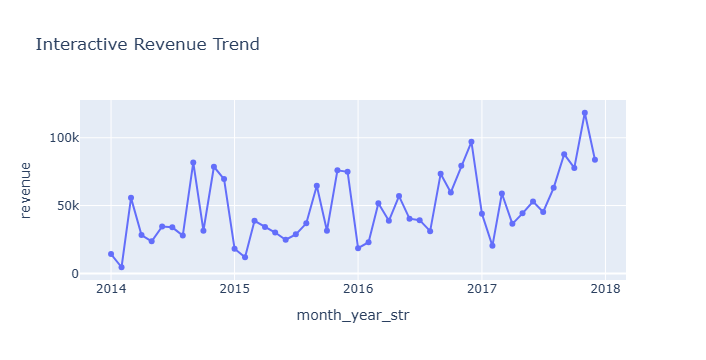

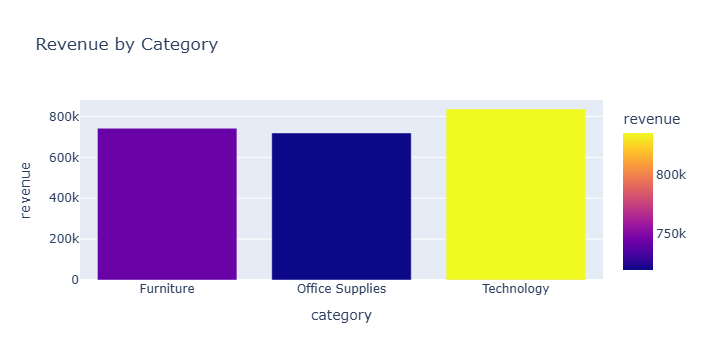

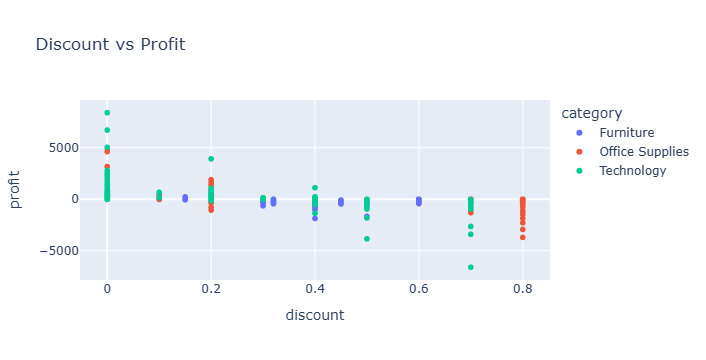

In [10]:
fig = px.line(monthly_sales, x='month_year_str', y='revenue', title="Interactive Revenue Trend", markers=True)
fig.show()

cat_revenue = df.groupby('category')['revenue'].sum().reset_index()
px.bar(cat_revenue, x='category', y='revenue', color='revenue', title="Revenue by Category").show()

px.scatter(df, x='discount', y='profit', color='category', title="Discount vs Profit").show()

In [11]:
rfm = df.groupby('customer_id').agg({
    'order_date':'max',
    'order_id':'nunique',
    'revenue':'sum'
}).rename(columns={'order_id':'frequency','revenue':'monetary'})

rfm['recency_days'] = (df['order_date'].max() - rfm['order_date']).dt.days

rfm['AOV'] = rfm['monetary'] / rfm['frequency'].replace(0,1)

rfm['R'] = pd.qcut(rfm['recency_days'], 4, labels=[4,3,2,1])
rfm['F'] = pd.qcut(rfm['frequency'].rank(method='first'), 4, labels=[1,2,3,4])
rfm['M'] = pd.qcut(rfm['monetary'], 4, labels=[1,2,3,4])

rfm['RFM_Score'] = rfm['R'].astype(int)*100 + rfm['F'].astype(int)*10 + rfm['M'].astype(int)

rfm.head()

,order_date,frequency,monetary,recency_days,AOV,R,F,M,RFM_Score
customer_id,,,,,,,,,
AA-10315,2017-06-29,5,5563.560,184,1112.712000,1,1,4,114
AA-10375,2017-12-11,9,1056.390,19,117.376667,4,4,1,441
AA-10480,2017-04-15,4,1790.512,259,447.628000,1,1,2,112
AA-10645,2017-11-05,6,5086.935,55,847.822500,3,2,4,324
AB-10015,2016-11-10,3,886.156,415,295.385333,1,1,1,111


In [12]:
avg_margin = df['margin_pct'].mean()
rfm['CLTV_simple'] = rfm['AOV'] * rfm['frequency'] * avg_margin

X = rfm[['recency_days','frequency','monetary','AOV']].fillna(0)
y = rfm['CLTV_simple']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gbr = GradientBoostingRegressor(n_estimators=200, random_state=42)
gbr.fit(X_train, y_train)

rfm['CLTV_pred'] = gbr.predict(X)

r2_score(y_test, gbr.predict(X_test))

0.9933967796577198

In [13]:
product = df.groupby('product_id').agg({
    'sales':'sum',
    'profit':'sum',
    'quantity':'sum',
    'discount':'mean',
    'price':'mean',
}).reset_index()

product['profit_margin'] = product['profit'] / product['sales']
product.head()

,product_id,sales,profit,quantity,discount,price,profit_margin
0,FUR-BO-10000112,825.174,-117.8820,9,0.300000,91.686000,-0.142857
1,FUR-BO-10000330,1064.624,24.1960,10,0.100000,108.882000,0.022727
2,FUR-BO-10000362,2154.348,311.1836,14,0.130000,148.752600,0.144444
3,FUR-BO-10000468,723.842,-133.1092,21,0.183333,39.673667,-0.183893
4,FUR-BO-10000711,851.760,229.9752,12,0.000000,70.980000,0.270000


In [15]:
OUTPUT_DIR = r"C:\Users\swati\Desktop\BPIS"
os.makedirs(OUTPUT_DIR, exist_ok=True)

ML_FEATURE_CSV = os.path.join(OUTPUT_DIR, "BPIS_full_features.csv")
df_ml.to_csv(ML_FEATURE_CSV, index=False)

print("Saved:", ML_FEATURE_CSV)

Saved: C:\Users\swati\Desktop\BPIS\BPIS_full_features.csv


In [16]:
df_ml['churn_180'] = (df_ml['recency_days'] > 180).astype(int)

cust = df_ml.groupby('customer_id').agg({
    'recency_days':'max',
    'frequency':'max',
    'monetary':'sum',
    'CLTV_pred':'max',
    'churn_180':'max'
}).reset_index()

X = cust[['recency_days','frequency','monetary','CLTV_pred']].fillna(0)
y = cust['churn_180'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

if xgb:
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
else:
    model = RandomForestClassifier(n_estimators=300, random_state=42)

model.fit(X_train, y_train)

churn_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
churn_auc

1.0

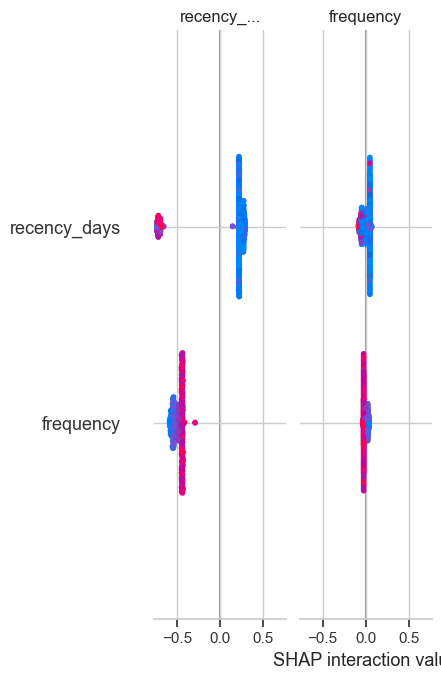

In [17]:
if shap:
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    shap.summary_plot(shap_values, X_train, plot_type="bar")
else:
    print("SHAP not installed.")

In [18]:
demand = df_ml.groupby(['product_id','month_year_str']).agg({
    'sales':'sum',
    'price':'mean',
    'discount':'mean',
    'quantity':'sum',
    'profit_margin':'mean'
}).reset_index()

X = demand[['price','discount','quantity','profit_margin']].fillna(0)
y = demand['sales']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

stack = StackingRegressor(
    estimators=[
        ('rf', RandomForestRegressor(n_estimators=200, random_state=42)),
        ('gbr', GradientBoostingRegressor(n_estimators=300, random_state=42))
    ],
    final_estimator=Ridge()
)

stack.fit(X_train, y_train)
r2_score(y_test, stack.predict(X_test))

0.9777795667992626

In [19]:
joblib.dump(model, MODELS_DIR/'churn_model.pkl')
joblib.dump(stack, MODELS_DIR/'demand_model.pkl')
joblib.dump(gbr, MODELS_DIR/'cltv_model.pkl')

print("Models saved.")

Models saved.


In [20]:
html_path = REPORTS_DIR / 'BPIS_Executive_Report.html'

html = f"""
<html><body style='font-family:Arial;margin:40px'>
<h1>BPIS Executive Summary</h1>

<h2>KPIs</h2>
<ul>
    <li>Total Revenue: {kpis['total_revenue']:.2f}</li>
    <li>Total Profit: {kpis['total_profit']:.2f}</li>
    <li>Avg Order Value: {kpis['avg_order_value']:.2f}</li>
    <li>Total Customers: {kpis['total_customers']}</li>
</ul>

<h2>Model Performance</h2>
<ul>
    <li>Churn Model ROC-AUC: {churn_auc:.3f}</li>
    <li>Demand Model R²: {r2_score(y_test, stack.predict(X_test)):.3f}</li>
</ul>

</body></html>
"""

with open(html_path, "w") as f:
    f.write(html)

html_path

WindowsPath('C:/Users/swati/Desktop/BPIS/reports/BPIS_Executive_Report.html')

In [22]:
# === FIXED CELL 19 — SAVE SCORING SCRIPT ON WINDOWS ===

import os

# Define your BPIS project folder on Windows
OUTPUT_DIR = r"C:\Users\swati\Desktop\BPIS"
os.makedirs(OUTPUT_DIR, exist_ok=True)

score_path = os.path.join(OUTPUT_DIR, "score_batch.py")

score_script = r'''
# score_batch.py — auto generated
import pandas as pd
import numpy as np
from pathlib import Path
import joblib

MODELS_DIR = Path(r"C:\Users\swati\Desktop\BPIS\models")

churn = joblib.load(MODELS_DIR / "churn_model.pkl")
demand = joblib.load(MODELS_DIR / "demand_model.pkl")

def preprocess(df):
    df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')
    df['price'] = (df['sales']/df['quantity']).replace([np.inf,-np.inf],0)
    df['month_year_str'] = df['order_date'].dt.to_period('M').astype(str)
    return df

def score(input_path, output_path):
    df = pd.read_csv(input_path)
    df = preprocess(df)

    # demand scoring
    X = df[['price','discount','quantity','profit_margin']].fillna(0)
    df['predicted_sales'] = demand.predict(X)

    # churn scoring
    cust = df.groupby('customer_id').agg({
        'order_date':'max',
        'order_id':'nunique',
        'sales':'sum'
    }).rename(columns={'order_id':'frequency','sales':'monetary'}).reset_index()

    cust['recency_days'] = (df['order_date'].max() - cust['order_date']).dt.days
    cust['CLTV_pred'] = cust['monetary'] * 0.1   # fallback if CLTV not present

    Xc = cust[['recency_days','frequency','monetary','CLTV_pred']].fillna(0)
    cust['churn_proba'] = churn.predict_proba(Xc)[:,1]

    out = df.merge(cust[['customer_id','churn_proba']], on='customer_id', how='left')
    out.to_csv(output_path, index=False)
    print("Saved:", output_path)

if __name__ == "__main__":
    score("input.csv","output_scored.csv")
'''

# Save the script
with open(score_path, "w") as f:
    f.write(score_script)

print("Scoring script saved to:", score_path)

Scoring script saved to: C:\Users\swati\Desktop\BPIS\score_batch.py
